In [111]:
import pandas as pd
import numpy as np
import uuid
import random
import seaborn as sns
import matplotlib.pyplot as plt
import scipy
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

%matplotlib inline
sns.set_style("ticks")

Olist conducted an experiment to see if altering the delivery estimation could result in higher review scores.

# Generate random data for A/B testing

In [2]:
date_range = pd.date_range(start="2018-07-01", end="2018-09-01")

In [3]:
date_range

DatetimeIndex(['2018-07-01', '2018-07-02', '2018-07-03', '2018-07-04',
               '2018-07-05', '2018-07-06', '2018-07-07', '2018-07-08',
               '2018-07-09', '2018-07-10', '2018-07-11', '2018-07-12',
               '2018-07-13', '2018-07-14', '2018-07-15', '2018-07-16',
               '2018-07-17', '2018-07-18', '2018-07-19', '2018-07-20',
               '2018-07-21', '2018-07-22', '2018-07-23', '2018-07-24',
               '2018-07-25', '2018-07-26', '2018-07-27', '2018-07-28',
               '2018-07-29', '2018-07-30', '2018-07-31', '2018-08-01',
               '2018-08-02', '2018-08-03', '2018-08-04', '2018-08-05',
               '2018-08-06', '2018-08-07', '2018-08-08', '2018-08-09',
               '2018-08-10', '2018-08-11', '2018-08-12', '2018-08-13',
               '2018-08-14', '2018-08-15', '2018-08-16', '2018-08-17',
               '2018-08-18', '2018-08-19', '2018-08-20', '2018-08-21',
               '2018-08-22', '2018-08-23', '2018-08-24', '2018-08-25',
      

In [4]:
np.datetime64("2018-07-15")

numpy.datetime64('2018-07-15')

In [5]:
control = {1: 10,
           2: 3,
           3: 8,
           4: 20,
           5: 59}

test = {1: 10,
        2: 2,
        3: 10,
        4: 22,
        5: 63}

def generate_review_distribution(freq_dict):
    l = []
    for key, value in freq_dict.items():
        l += [key] * value
    return l

In [6]:
def get_random_review(date, group):
    if (group == 102) & (date >= np.datetime64("2018-07-15")):
        random_reviews = generate_review_distribution(test)
    else:
        random_reviews = generate_review_distribution(control)
    return random.choice(random_reviews)
    
def generate_random_observation(date, group):
    return str(uuid.uuid4()), get_random_review(date, group)

In [7]:
# create list of dicts to later on convert to a dataframe
rows = []
for date in date_range:
    # two groups
    for group in [101,102]:
        # pick a random number of orders btw 350 and 450
        orders = random.choice(range(350,450))
        for obs in range(orders):
            order_id, review_score = generate_random_observation(date, group)
            rows.append({"date_id": date,
                         "experiment_id": group,
                         "order_id": order_id,
                         "review_score": review_score})
            
df = pd.DataFrame(rows)

### Plot data and calculate means

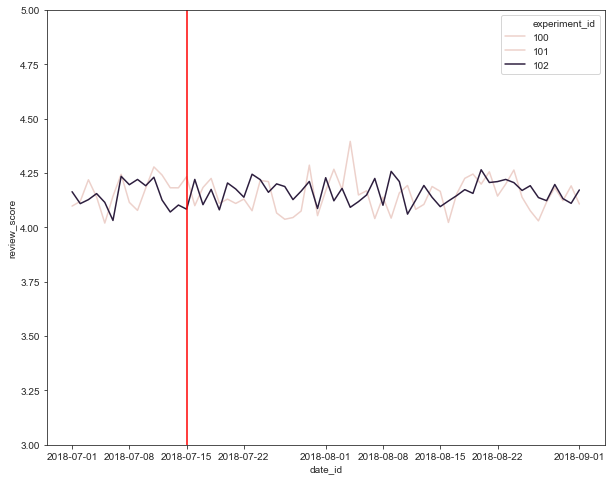

In [8]:
fig, ax = plt.subplots(figsize=(10,8))
sns.lineplot(data=df.groupby(["date_id", "experiment_id"]).mean().reset_index(),
             x="date_id",
             y="review_score",
             hue="experiment_id",
             ax=ax);
ax.axvline("2018-07-15", color="r")
ax.set_ylim(3,5);

In [9]:
df[df["date_id"] > "2018-07-15"].groupby("experiment_id").mean()

,review_score
experiment_id,
101,4.149319
102,4.165813


In [10]:
df.to_csv("olist_experiment_data.csv")

How do we know if this difference did not just occur by chance?
We have uncertainty because we are looking at a sample and want to generalize to all users.


We use statistics => t-test

# Central Limit Theorem

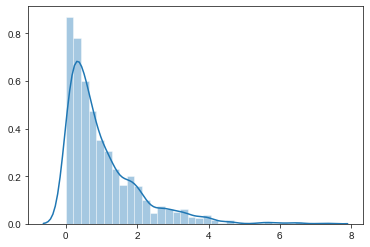

In [35]:
sns.distplot(np.random.exponential(size=1000));

In [48]:
sample = np.random.exponential(size=1000)

In [49]:
sample.mean()

0.9140553395000942

In [50]:
def sample_from_distr(sample_size, rep):
    return [np.random.exponential(size=sample_size).mean() for r in range(rep)]

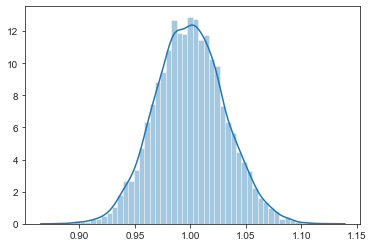

In [51]:
sns.distplot(sample_from_distr(1000, 10000));

In [62]:
def plot_hist(sample_size, rep, distr):
    sns.distplot([distr(size=sample_size).mean() for r in range(rep)])

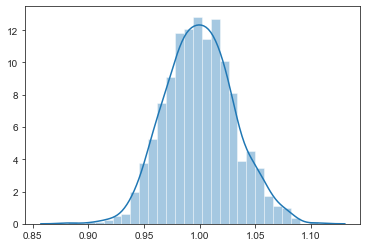

In [47]:
plot_hist(1000, 1000)

Try a different dfistribution

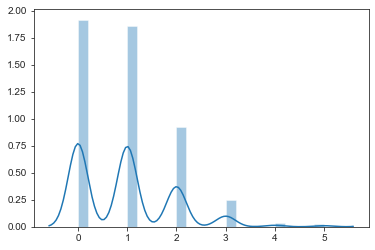

In [60]:
sns.distplot(np.random.poisson(size=1000));

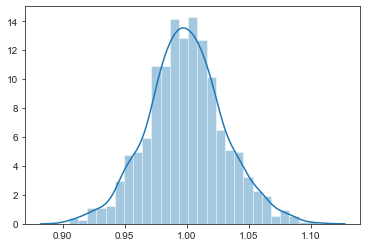

In [68]:
plot_hist(1000, 1000, np.random.poisson)

In [74]:
def plot_hist(sample_size, rep, distr, color=None, ax=None):
    sns.distplot([distr(size=sample_size).mean() for r in range(rep)],
                 color=color,
                 ax=ax)

Tweak sample size parameter

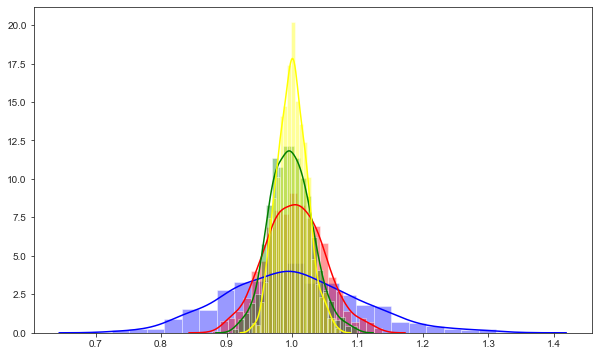

In [86]:
fig, ax = plt.subplots(figsize=(10,6))

# sample_size=100
plot_hist(100, 1000, np.random.exponential, color="blue", ax=ax)

# sample_size=500
plot_hist(500, 1000, np.random.exponential, color="red", ax=ax)

# sample_size=1000
plot_hist(1000, 1000, np.random.exponential, color="green", ax=ax)

# sample_size=100
plot_hist(2000, 1000, np.random.exponential, color="yellow", ax=ax)

By increasing the sample size, while holding other parameters constant, the shape of our normal distribution gets slimmer.

Tweak repetition parameter

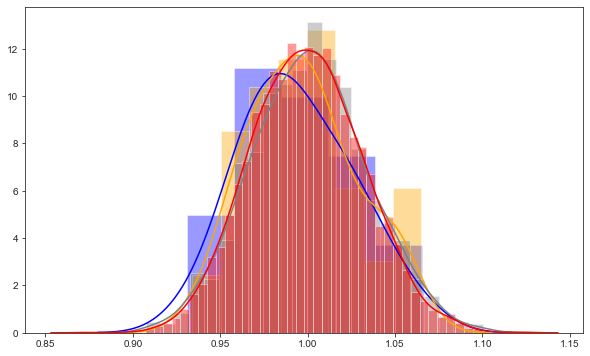

In [90]:
fig, ax = plt.subplots(figsize=(10,6))

# rep=30
plot_hist(1000, 30, np.random.exponential, color="blue", ax=ax)

# rep=100
plot_hist(1000, 100, np.random.exponential, color="orange", ax=ax)

# rep=1000
plot_hist(1000, 1000, np.random.exponential, color="grey", ax=ax)

# rep=5000
plot_hist(1000, 5000, np.random.exponential, color="red", ax=ax)

By tweaking the repetitions parameter, the normal distribution does not seem to change

# Analysis

Nullhypothesis:

$H_0: avg\_score_{control} = avg\_score_{test}$

$H_0: avg\_score_{control} - avg\_score_{test} = 0$

using a t-test

In [93]:
df_exp = df[df["date_id"] >= "2018-07-15"].copy()

In [94]:
df_exp.head()

,date_id,experiment_id,order_id,review_score
11159,2018-07-15,101,2da35232-ea23-4582-a7af-b02601b487a6,5
11160,2018-07-15,101,9649ea4e-e69d-4311-a12e-c2c51e08a98e,5
11161,2018-07-15,101,bd3377fb-fc25-4547-8f01-5dd7d458e7b6,5
11162,2018-07-15,101,17d1b20d-ded3-4001-bdbc-8ccfd1291fe2,5
11163,2018-07-15,101,2bab6ef8-7f93-4ba9-9670-20edb5738bec,5


In [95]:
means = (df_exp
         .groupby("experiment_id")
         .agg({"review_score": "mean"}))

means

,review_score
experiment_id,
101,4.151159
102,4.164100


In [96]:
var = (df_exp
       .groupby("experiment_id")
       .agg({"review_score": "var"}))

var

,review_score
experiment_id,
101,1.674715
102,1.609699


In [97]:
std = (df_exp
       .groupby("experiment_id")
       .agg({"review_score": "std"}))

std

,review_score
experiment_id,
101,1.294108
102,1.268739


In [98]:
ssize = (df_exp
         .groupby("experiment_id")
         .agg({"review_score": "count"}))

ssize

,review_score
experiment_id,
101,19754
102,19543


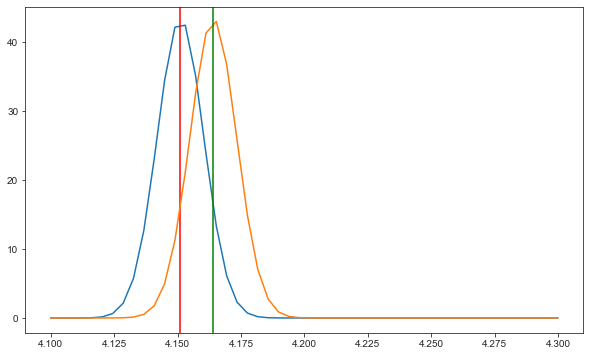

In [115]:
fig, ax = plt.subplots(figsize=(10,6))

x = np.linspace(4.1, 4.3)
se_1 = std.loc[101, "review_score"] / np.sqrt(ssize.loc[101, "review_score"])
pdf_1 = scipy.stats.norm.pdf(x,
                             means.loc[101, "review_score"],
                             se_1)

plt.plot(x, pdf_1);
ax.axvline(means.loc[101, "review_score"], color="r");

se_2 = std.loc[102, "review_score"] / np.sqrt(ssize.loc[102, "review_score"])
pdf_2 = scipy.stats.norm.pdf(x,
                             means.loc[102, "review_score"],
                             se_1)

plt.plot(x, pdf_2);
ax.axvline(means.loc[102, "review_score"], color="g");

Combine the two distributions

In [116]:
se_c = np.sqrt(var.loc[101, "review_score"]/ssize.loc[101, "review_score"] + var.loc[102, "review_score"]/ssize.loc[102, "review_score"])
diff_mean = means.loc[101, "review_score"] - means.loc[102, "review_score"]

In [117]:
diff_mean

-0.012940418749659344

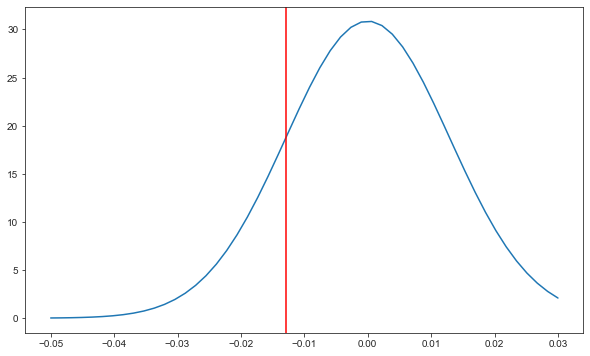

In [125]:
fig, ax = plt.subplots(figsize=(10,6))

x_c = np.linspace(-.05,.03)
pdf_c = scipy.stats.norm.pdf(x_c,
                             0,
                             se_c)

plt.plot(x_c, pdf_c);
ax.axvline(diff_mean, color="r");

In [126]:
diff_mean / se_c

-1.0009236394744545

In [127]:
scipy.stats.ttest_ind(df_exp.loc[df_exp["experiment_id"] == 101, "review_score"],
                      df_exp.loc[df_exp["experiment_id"] == 102, "review_score"],
                      equal_var=False)

Ttest_indResult(statistic=-1.0009236394744558, pvalue=0.316869890815575)

## Interpreting the p-value

**Generally:**
Given our data, assuming the null hypothesis is true, the likelihood of obtaining the value we observe or more extreme, is the p-value.

**In our case:**
Given our sample, the likelihood that we observe a difference in the two means of -0.01294 or more extreme, assuming there is no difference, is 31.69%


## Statistical significance

We **may** reject the null hypothesis, if the p-value is smaller or equal to 0.05 (alpha-level). If we reject the null hypothesis, we conclude statistical significance. 

We reject the null hypothesis, if the p-value is smaller or equal to the set alpha-level. If we reject the null hypothesis, we conclude statistical significance. 

If the p-value would have been below or equal to 0.05, the difference in the means would have been statistically significant.